# Exploratory Data Analysis for Laser Powder Bed Fusion (LPBF) Experiments

## Introduction

Welcome to the Exploratory Data Analysis (EDA) notebook for Laser Powder Bed Fusion (LPBF) Experiments. This notebook aims to analyze and visualize the key features and characteristics of the optical data collected during the LPBF process. Through statistical methods, Fourier Transform analysis, and clustering techniques, we strive to gain insights that can help improve the LPBF process and guide future experiments.



In [1]:
import pandas as pd
import pickle

# Define the cube number
cube = 5

# Load final_data_list
with open(f'./Data/final_data_list_cube_{cube}.pkl', 'rb') as f:
    final_data_list = pickle.load(f)

# Define the path to the Excel file
excel_path = './Parameters.xlsx'  

# Define the page to be used
sheet_name = f"Cube {cube}"

# Try to read the Excel file into a DataFrame
try:
    df_conditions = pd.read_excel(excel_path, sheet_name=sheet_name)
    print("Successfully read the Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")



Successfully read the Excel file.


In [2]:
df_conditions

,Speed (mm/s),Powers (W),Powers perc (%),#
0,966.666667,106.666667,21.333333,1
1,1633.333333,106.666667,21.333333,2
2,1466.666667,120.000000,24.000000,3
3,633.333333,120.000000,24.000000,4
4,1800.000000,120.000000,24.000000,5
5,1133.333333,80.000000,16.000000,6
6,800.000000,120.000000,24.000000,7
7,1300.000000,93.333333,18.666667,8
8,1300.000000,80.000000,16.000000,9
9,633.333333,93.333333,18.666667,10


In [31]:
final_data_list[0].shape

(2, 10, 968)

In [3]:
def get_condition_info(condition_number, df_conditions):
    """
    Retrieve information for a specific condition number from the DataFrame.

    Parameters:
    - condition_number: int, the condition number
    - df_conditions: pandas DataFrame, the DataFrame containing condition information

    Returns:
    - info_dict: Dictionary containing information for the specified condition
    """
    # Filter the DataFrame to get the row corresponding to the condition number
    # Note: In Parameters.xlsx, the column holding the condition number is labeled "#"
    condition_row = df_conditions[df_conditions['#'] == condition_number]

    # If no matching condition is found, return an empty dictionary
    if condition_row.empty:
        return {}

    # Convert the row to a dictionary
    info_dict = condition_row.iloc[0].to_dict()

    return info_dict

# Example
condition_number = 1
condition_info = get_condition_info(condition_number, df_conditions)
print(f"Information for condition {condition_number}: {condition_info}")


Information for condition 1: {'Speed (mm/s)': 966.6666666666666, 'Powers (W)': 106.6666666666667, 'Powers perc (%)': 21.33333333333334, '#': 1.0}


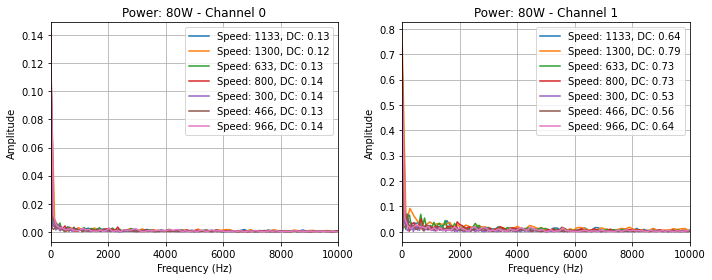

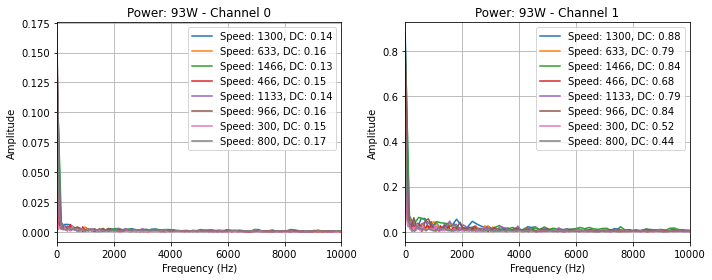

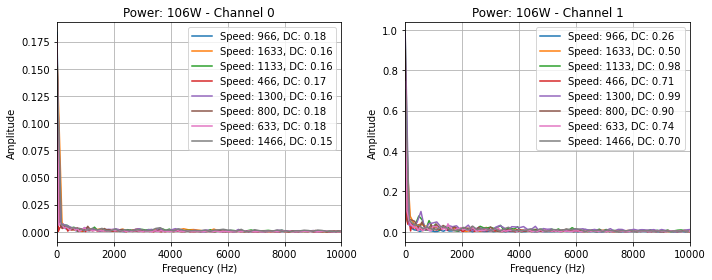

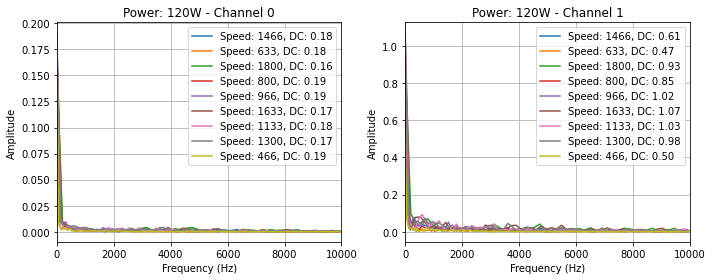

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

# Ensure the 'Figures' folder exists
if not os.path.exists('./Figures'):
    os.makedirs('./Figures')

# Sampling frequency
fs = 100000  # in Hz

# Frequency limit
freq_limit = 10000  # 10 kHz

# Extract unique power levels
unique_powers = set()
for condition_number in range(len(final_data_list)):
    condition_info = get_condition_info(condition_number + 1, df_conditions)
    unique_powers.add(condition_info['Powers (W)'])
unique_powers = sorted(list(unique_powers))

# Loop through all unique power levels
for power in unique_powers:
    plt.figure(figsize=(10, 4))

    # Separate subplots for each channel
    for channel in range(2):
        plt.subplot(1, 2, channel + 1)

        # Loop through all conditions
        for condition_number in range(len(final_data_list)):
            condition_info = get_condition_info(condition_number + 1, df_conditions)
            
            # Check if the condition matches the current power level
            if condition_info['Powers (W)'] == power:
                condition_data = final_data_list[condition_number]
                
                # Average the last 8 segments for the current channel
                avg_data = np.median(condition_data[channel][2:, :], axis=0)
                
                # Perform FFT
                fft_values = fft(avg_data)/avg_data.shape[0]
                freqs = np.fft.fftfreq(len(fft_values), 1/fs)
                
                # Capture the DC value (FFT at bin 0)
                dc_value = np.abs(fft_values[0])
                
                # Filter frequencies to be below 10 kHz
                positive_freqs = freqs[:len(freqs)//2]
                valid_indices = np.where(positive_freqs <= freq_limit)[0]
                
                # Plot the FFT, considering only the positive frequencies and up to 10 kHz
                plt.plot(positive_freqs[valid_indices], np.abs(fft_values)[:len(freqs)//2][valid_indices], label=f"Speed: {int(condition_info['Speed (mm/s)'])}, DC: {dc_value:.2f}")

        plt.title(f"Power: {int(power)}W - Channel {channel}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.xlim([0, freq_limit])
        #plt.ylim([0, 300])
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'./Figures/Power_{power}W.png', dpi=600)
    
    plt.show()


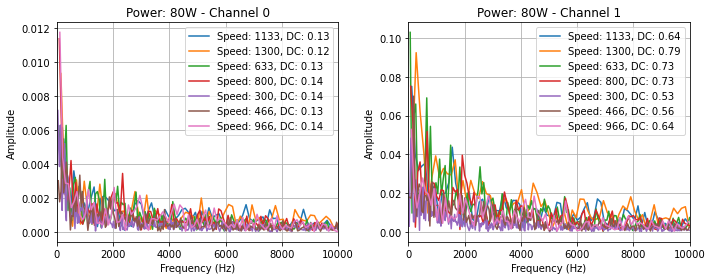

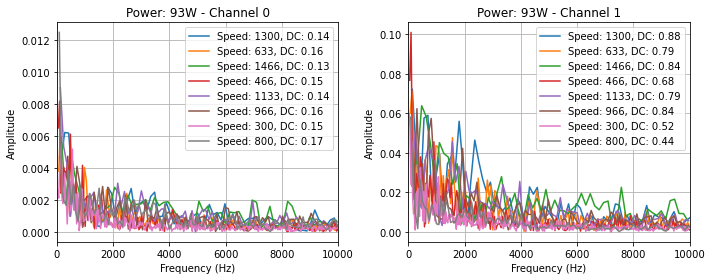

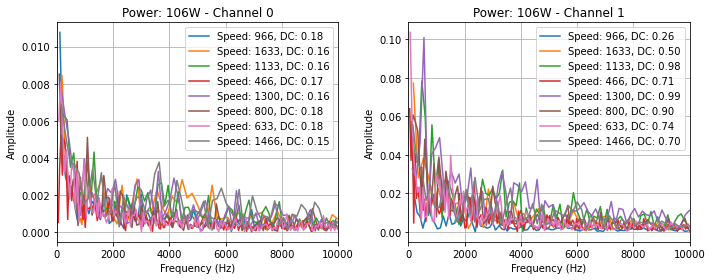

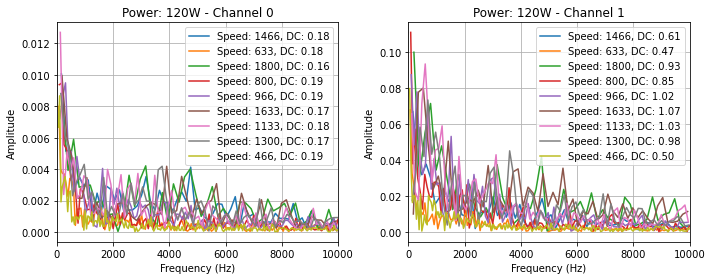

In [6]:
# Sampling frequency
fs = 100000  # in Hz

# Frequency limit
freq_limit = 10000  # 10 kHz

# Extract unique power levels
unique_powers = set()
for condition_number in range(len(final_data_list)):
    condition_info = get_condition_info(condition_number + 1, df_conditions)
    unique_powers.add(condition_info['Powers (W)'])
unique_powers = sorted(list(unique_powers))

# Loop through all unique power levels
for power in unique_powers:
    plt.figure(figsize=(10, 4))

    # Separate subplots for each channel
    for channel in range(2):
        plt.subplot(1, 2, channel + 1)

        # Loop through all conditions
        for condition_number in range(len(final_data_list)):
            condition_info = get_condition_info(condition_number + 1, df_conditions)
            
            # Check if the condition matches the current power level
            if condition_info['Powers (W)'] == power:
                condition_data = final_data_list[condition_number]
                
                # Average the first 8 segments for the current channel
                avg_data = np.median(condition_data[channel][2:, :], axis=0)
                
                # Perform FFT
                fft_values = fft(avg_data)/avg_data.shape[0]
                freqs = np.fft.fftfreq(len(fft_values), 1/fs)
                
                # Capture the DC value (FFT at bin 0)
                dc_value = np.abs(fft_values[0])
                
                # Filter frequencies to be below 10 kHz and exclude 0 Hz
                positive_freqs = freqs[:len(freqs)//2]
                valid_indices = np.where((positive_freqs <= freq_limit) & (positive_freqs > 0))[0]
                
                # Plot the FFT, considering only the positive frequencies and up to 10 kHz, excluding 0 Hz
                plt.plot(positive_freqs[valid_indices], np.abs(fft_values)[:len(freqs)//2][valid_indices], label=f"Speed: {int(condition_info['Speed (mm/s)'])}, DC: {dc_value:.2f}")

        plt.title(f"Power: {int(power)}W - Channel {channel}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.xlim([0, freq_limit])
        #plt.ylim([0, 100])
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'./Figures/FFT_Power_{power}W_noDC.png', dpi=600)
    
    plt.show()


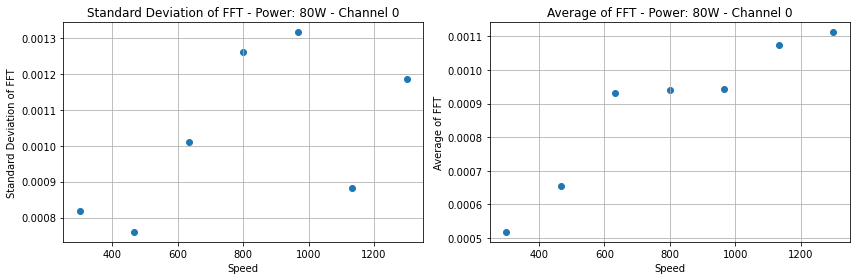

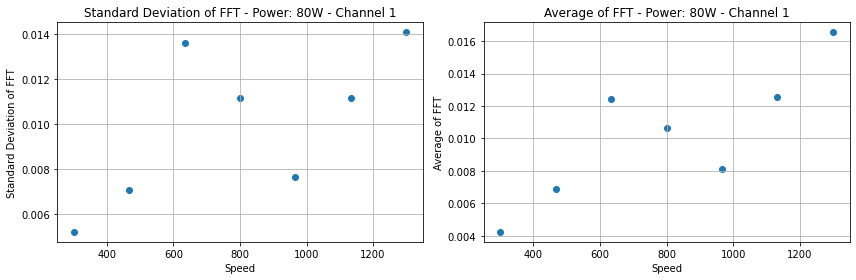

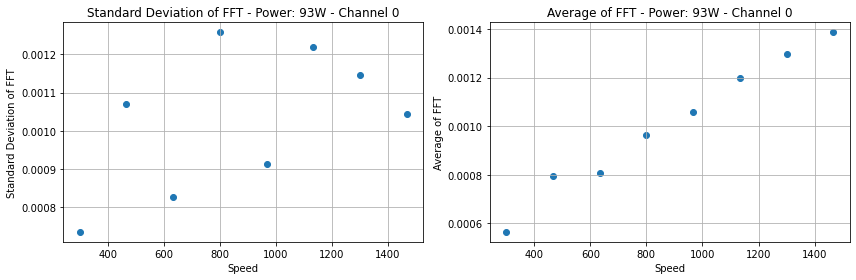

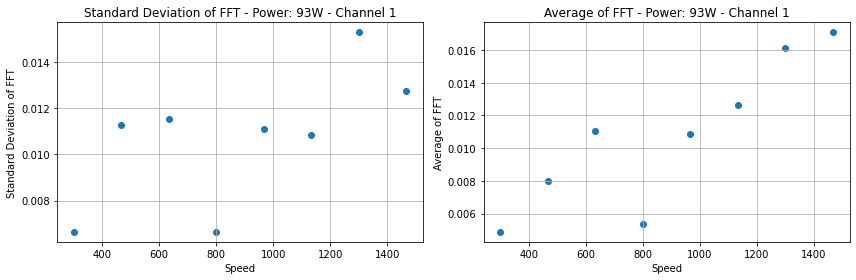

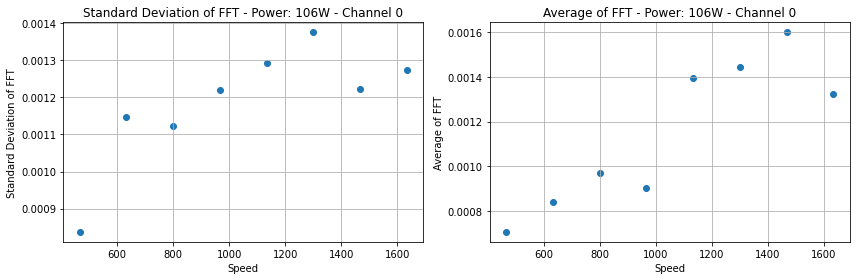

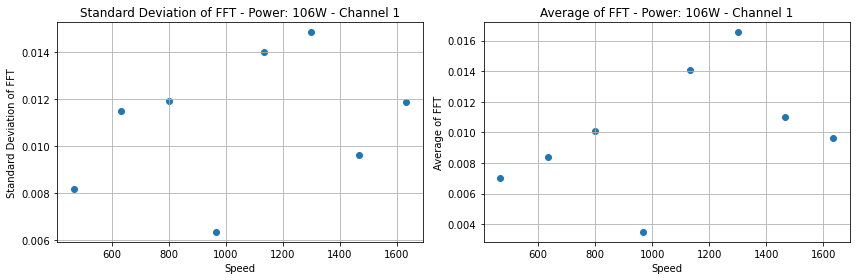

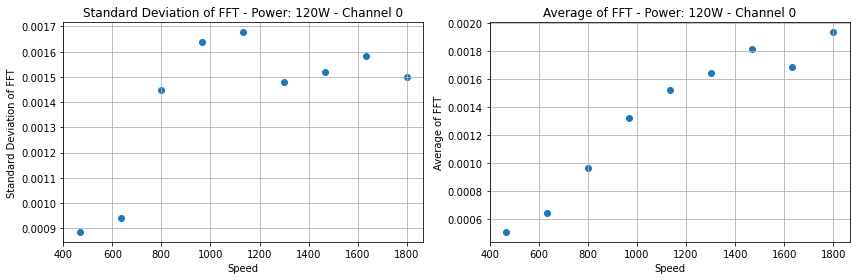

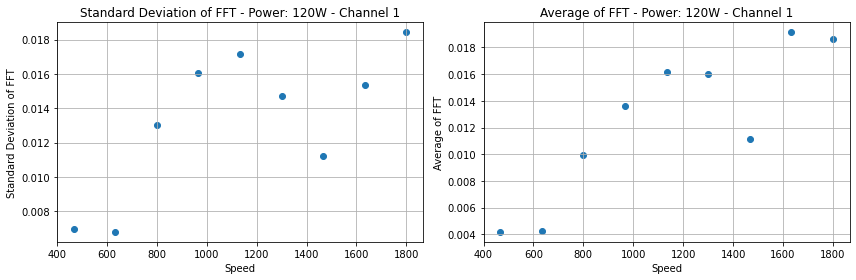

In [7]:
# Sampling frequency
fs = 100000  # in Hz

# Frequency limit
freq_limit = 10000  # 10 kHz

# Initialize dictionaries to hold FFT statistics
fft_stats = {}

# Extract unique power levels
unique_powers = set()
for condition_number in range(len(final_data_list)):
    condition_info = get_condition_info(condition_number + 1, df_conditions)
    unique_powers.add(condition_info['Powers (W)'])
unique_powers = sorted(list(unique_powers))

# Loop through all unique power levels
for power in unique_powers:
    fft_stats[power] = {'Channel 0': {'Speed': [], 'Average': [], 'StdDev': []},
                         'Channel 1': {'Speed': [], 'Average': [], 'StdDev': []}}
    
    # Loop through all conditions
    for condition_number in range(len(final_data_list)):
        condition_info = get_condition_info(condition_number + 1, df_conditions)
        
        # Check if the condition matches the current power level
        if condition_info['Powers (W)'] == power:
            condition_data = final_data_list[condition_number]
            
            # Loop through each channel
            for channel in range(2):
                # Average the last 8 segments for the current channel
                avg_data = np.median(condition_data[channel][2:, :], axis=0)
                
                # Perform FFT
                fft_values = np.fft.fft(avg_data) / avg_data.shape[0]
                freqs = np.fft.fftfreq(len(fft_values), 1/fs)
                
                # Filter frequencies to be below 10 kHz and exclude 0 Hz
                positive_freqs = freqs[:len(freqs)//2]
                valid_indices = np.where((positive_freqs <= freq_limit) & (positive_freqs > 0))[0]
                
                # Calculate average and standard deviation of the FFT values
                fft_avg = np.mean(np.abs(fft_values)[:len(freqs)//2][valid_indices])
                fft_std = np.std(np.abs(fft_values)[:len(freqs)//2][valid_indices])
                
                # Update fft_stats dictionary
                fft_stats[power][f'Channel {channel}']['Speed'].append(condition_info['Speed (mm/s)'])
                fft_stats[power][f'Channel {channel}']['Average'].append(fft_avg)
                fft_stats[power][f'Channel {channel}']['StdDev'].append(fft_std)
    
    # Plot the FFT statistics for each channel
    for channel in range(2):
        plt.figure(figsize=(12, 4))

        # Plot Standard Deviation
        plt.subplot(1, 2, 1)
        plt.scatter(fft_stats[power][f'Channel {channel}']['Speed'], fft_stats[power][f'Channel {channel}']['StdDev'])
        plt.title(f"Standard Deviation of FFT - Power: {int(power)}W - Channel {channel}")
        plt.xlabel("Speed")
        plt.ylabel("Standard Deviation of FFT")
        plt.grid(True)

        # Plot Average
        plt.subplot(1, 2, 2)
        plt.scatter(fft_stats[power][f'Channel {channel}']['Speed'], fft_stats[power][f'Channel {channel}']['Average'])
        plt.title(f"Average of FFT - Power: {int(power)}W - Channel {channel}")
        plt.xlabel("Speed")
        plt.ylabel("Average of FFT")
        plt.grid(True)

        plt.tight_layout()
        
        # Save the plot
        plt.savefig(f'./Figures/FFT_Stats_Power_{int(power)}W_Channel_{channel}.png', dpi=600)
        
        plt.show()


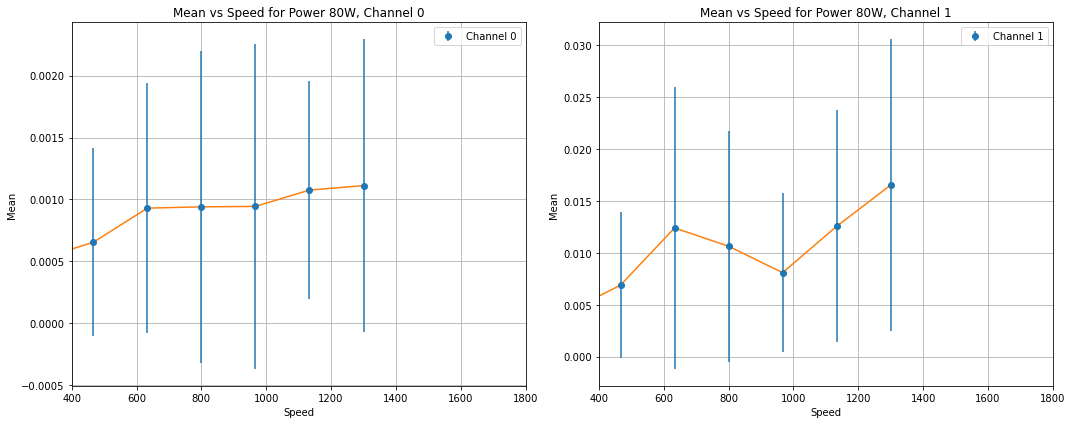

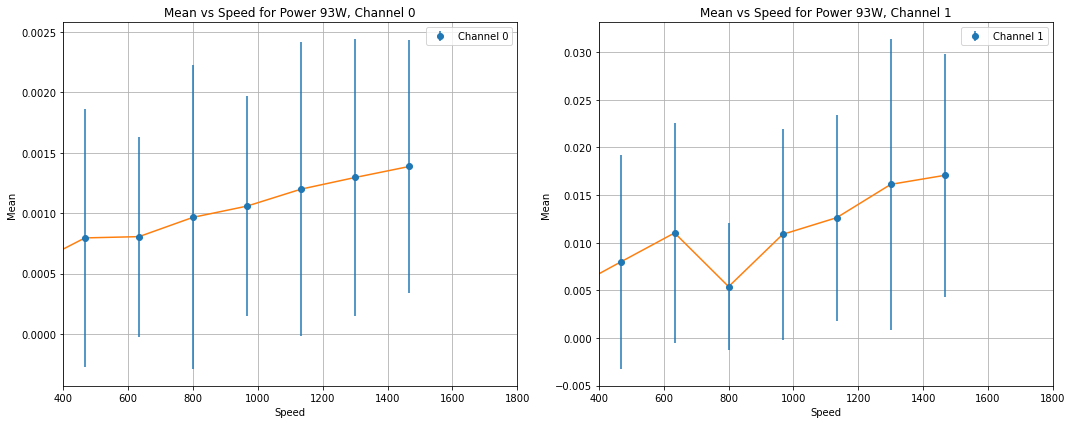

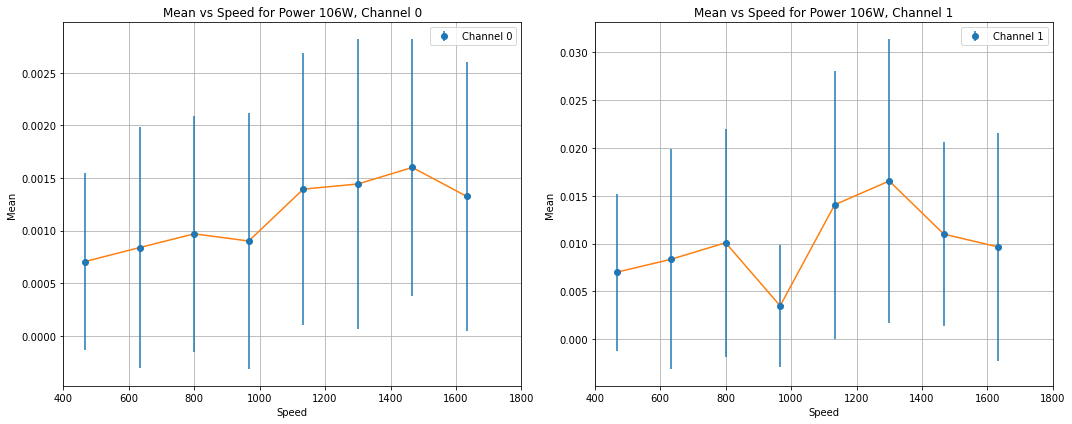

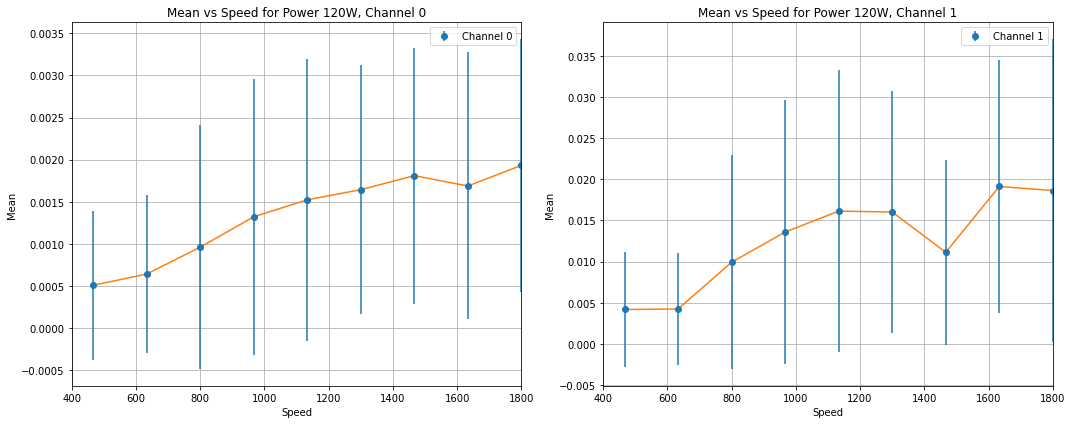

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through unique power levels
for power in unique_powers:
    # Initialize data containers for the plots
    mean_data = {'channel_0': [], 'channel_1': []}
    std_data = {'channel_0': [], 'channel_1': []}
    speeds = []
    
    for channel in [0, 1]:
        # Retrieve speed, mean, and std data from fft_stats dictionary
        speeds = fft_stats[power][f'Channel {channel}']['Speed']
        mean_data[f'channel_{channel}'] = fft_stats[power][f'Channel {channel}']['Average']
        std_data[f'channel_{channel}'] = fft_stats[power][f'Channel {channel}']['StdDev']
    
    # Sort data by speed
    sorted_indices = np.argsort(speeds)
    speeds = np.array(speeds)[sorted_indices]
    
    for channel in [0, 1]:
        mean_data[f'channel_{channel}'] = np.array(mean_data[f'channel_{channel}'])[sorted_indices]
        std_data[f'channel_{channel}'] = np.array(std_data[f'channel_{channel}'])[sorted_indices]
    
    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    for channel in [0, 1]:
        # Plot error bars
        axs[channel].errorbar(speeds, mean_data[f'channel_{channel}'], yerr=std_data[f'channel_{channel}'], fmt='o', label=f'Channel {channel}')
        # Plot the line connecting the dots
        axs[channel].plot(speeds, mean_data[f'channel_{channel}'], linestyle='-', marker='')
        
        axs[channel].set_title(f'Mean vs Speed for Power {int(power)}W, Channel {channel}')
        axs[channel].set_xlabel('Speed')
        axs[channel].set_ylabel('Mean')
        axs[channel].set_xlim([400, 1800])
        axs[channel].legend()
        axs[channel].grid(True)
        
    plt.tight_layout()
    plt.show()


In [9]:
# Initialize dictionaries to hold statistics
stats = {}

# Loop through all unique power levels
for power in unique_powers:
    stats[power] = {'Channel 0': {'Speed': [], 'Median': [], 'StdDev': []},
                    'Channel 1': {'Speed': [], 'Median': [], 'StdDev': []}}
    
    # Loop through all conditions
    for condition_number in range(len(final_data_list)):
        condition_info = get_condition_info(condition_number + 1, df_conditions)
        
        # Check if the condition matches the current power level
        if condition_info['Powers (W)'] == power:
            condition_data = final_data_list[condition_number]
            
            # Loop through each channel
            for channel in range(2):
                # Median of the last 8 segments for the current channel
                median_data = np.median(condition_data[channel][2:, :], axis=0)
                
                # Standard Deviation of the median data
                std_data = np.std(median_data, axis=0)
                
                # Update stats dictionary
                stats[power][f'Channel {channel}']['Speed'].append(condition_info['Speed (mm/s)'])
                stats[power][f'Channel {channel}']['Median'].append(np.median(median_data))
                stats[power][f'Channel {channel}']['StdDev'].append(std_data)


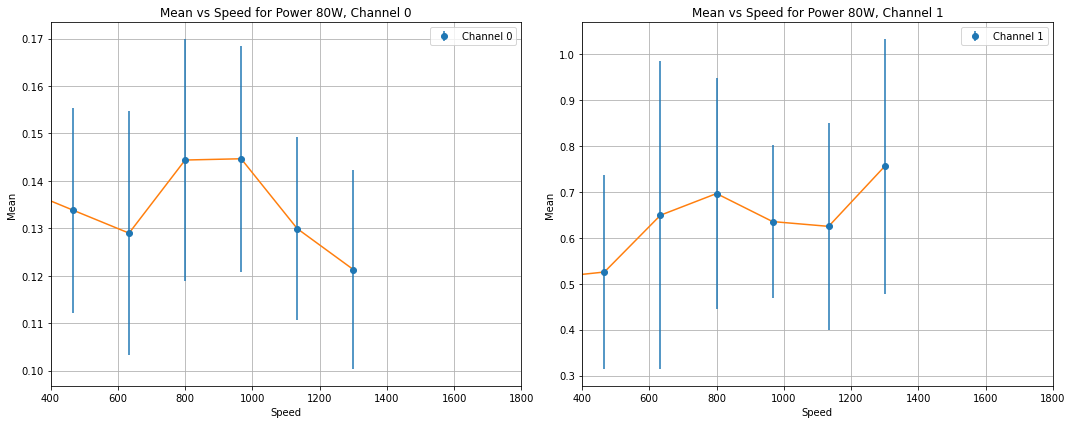

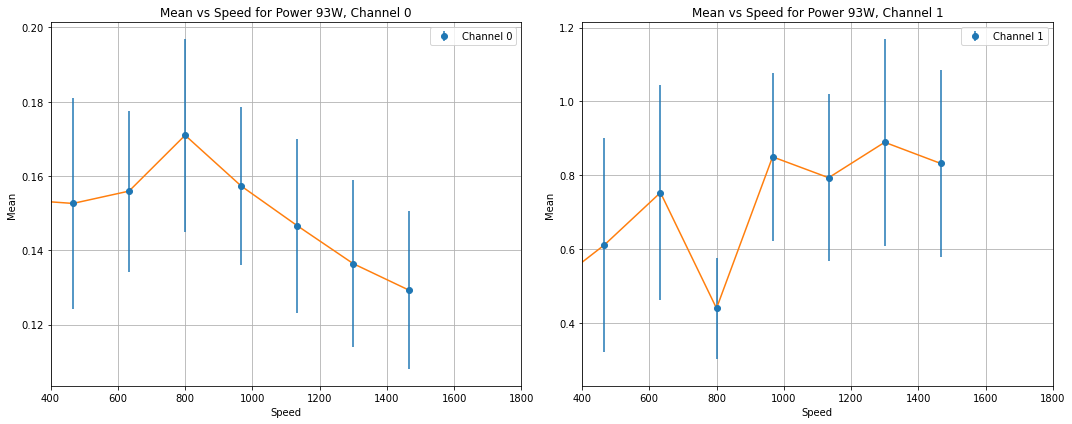

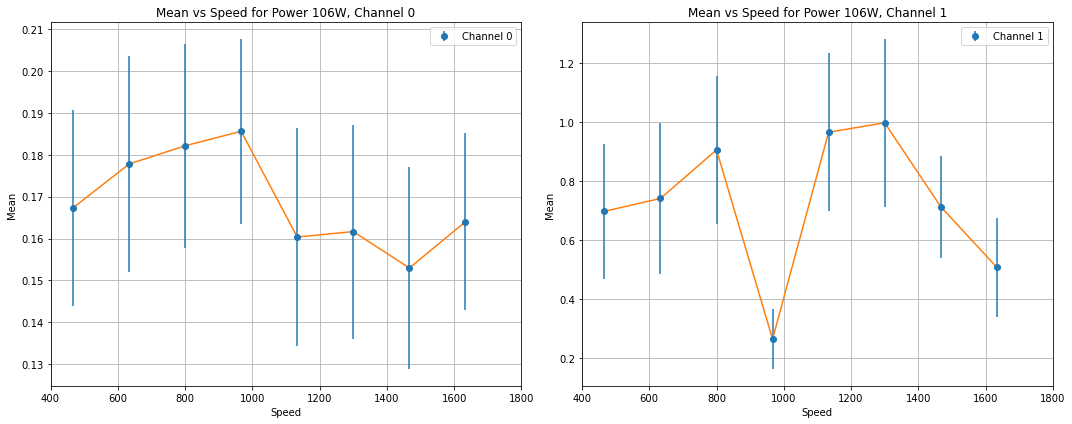

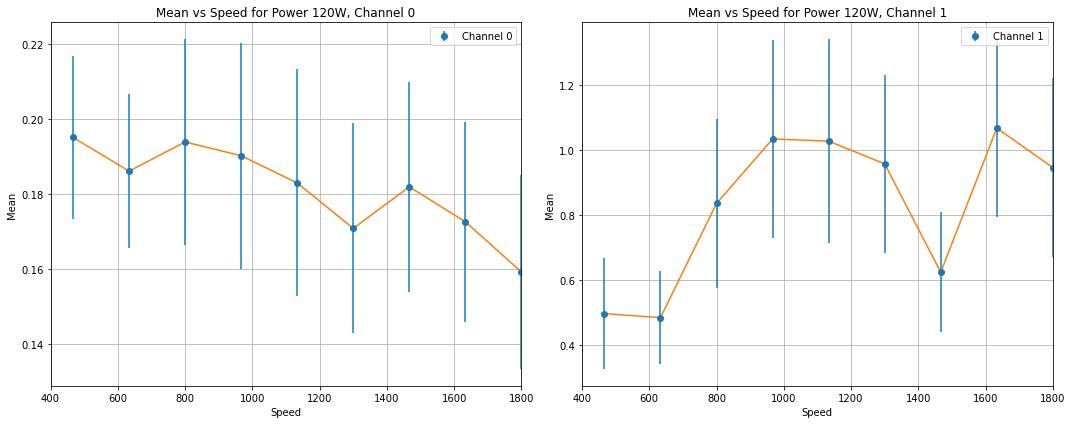

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through unique power levels
for power in unique_powers:
    # Initialize data containers for the plots
    mean_data = {'channel_0': [], 'channel_1': []}
    std_data = {'channel_0': [], 'channel_1': []}
    speeds = []
    
    for channel in [0, 1]:
        # Retrieve speed, mean, and std data from stats dictionary
        speeds = stats[power][f'Channel {channel}']['Speed']
        mean_data[f'channel_{channel}'] = stats[power][f'Channel {channel}']['Median']
        std_data[f'channel_{channel}'] = stats[power][f'Channel {channel}']['StdDev']
    
    # Sort data by speed
    sorted_indices = np.argsort(speeds)
    speeds = np.array(speeds)[sorted_indices]
    
    for channel in [0, 1]:
        mean_data[f'channel_{channel}'] = np.array(mean_data[f'channel_{channel}'])[sorted_indices]
        std_data[f'channel_{channel}'] = np.array(std_data[f'channel_{channel}'])[sorted_indices]
    
    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    for channel in [0, 1]:
        # Plot error bars
        axs[channel].errorbar(speeds, mean_data[f'channel_{channel}'], yerr=std_data[f'channel_{channel}'], fmt='o', label=f'Channel {channel}')
        # Plot the line connecting the dots
        axs[channel].plot(speeds, mean_data[f'channel_{channel}'], linestyle='-', marker='')
        
        axs[channel].set_title(f'Mean vs Speed for Power {int(power)}W, Channel {channel}')
        axs[channel].set_xlabel('Speed')
        axs[channel].set_ylabel('Mean')
        axs[channel].set_xlim([400, 1800])
        axs[channel].legend()
        axs[channel].grid(True)
        
    plt.tight_layout()
    plt.show()


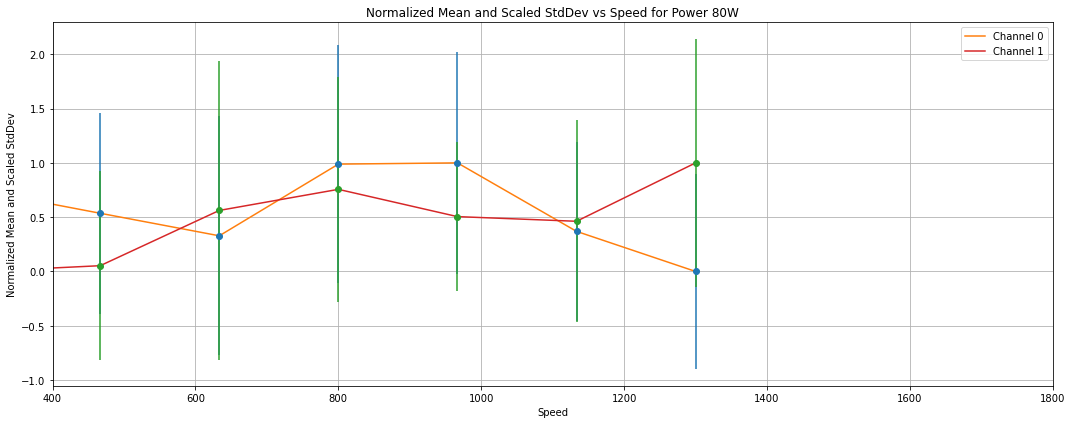

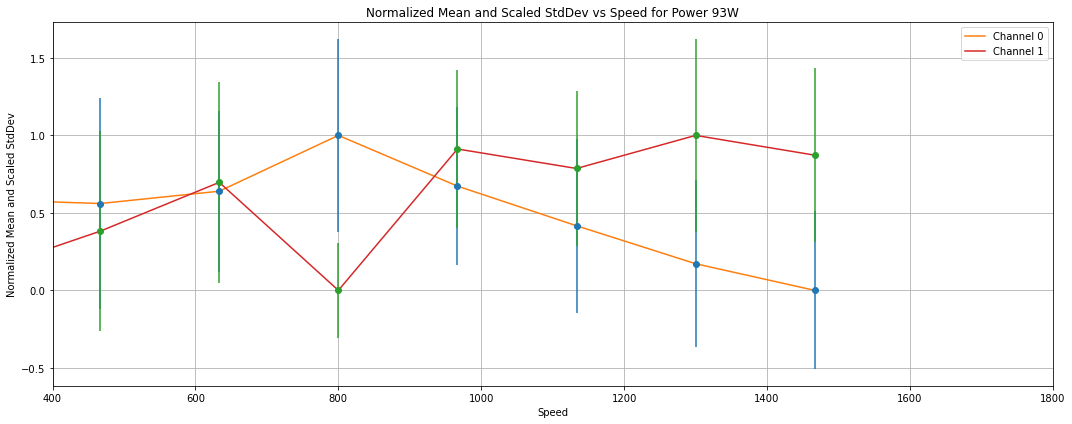

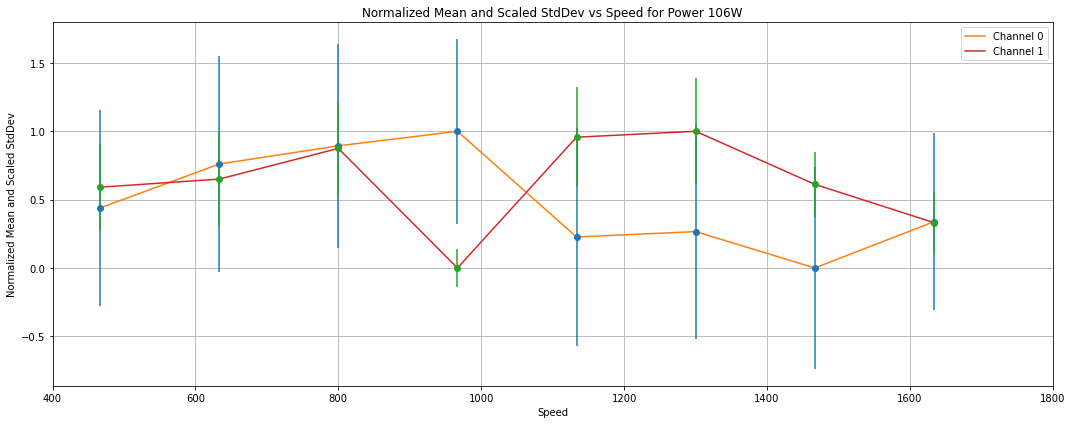

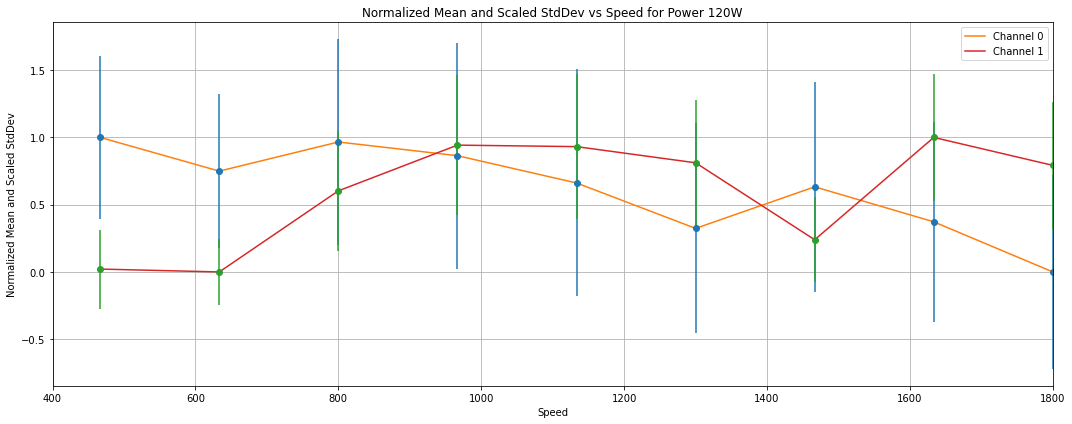

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through unique power levels
for power in unique_powers:
    # Initialize data containers for the plots
    mean_data = {'channel_0': [], 'channel_1': []}
    std_data = {'channel_0': [], 'channel_1': []}
    speeds = []
    
    for channel in [0, 1]:
        # Retrieve speed, mean, and std data from stats dictionary
        speeds = stats[power][f'Channel {channel}']['Speed']
        mean_data[f'channel_{channel}'] = stats[power][f'Channel {channel}']['Median']
        std_data[f'channel_{channel}'] = stats[power][f'Channel {channel}']['StdDev']
    
    # Sort data by speed
    sorted_indices = np.argsort(speeds)
    speeds = np.array(speeds)[sorted_indices]
    
    for channel in [0, 1]:
        mean_data[f'channel_{channel}'] = np.array(mean_data[f'channel_{channel}'])[sorted_indices]
        std_data[f'channel_{channel}'] = np.array(std_data[f'channel_{channel}'])[sorted_indices]
        
        # Normalize the mean data and scale the standard deviation
        min_val = np.min(mean_data[f'channel_{channel}'])
        max_val = np.max(mean_data[f'channel_{channel}'])
        scaling_factor = 1 / (max_val - min_val)
        
        mean_data[f'channel_{channel}'] = (mean_data[f'channel_{channel}'] - min_val) * scaling_factor
        std_data[f'channel_{channel}'] = std_data[f'channel_{channel}'] * scaling_factor
    
    # Create a single plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for channel in [0, 1]:
        # Plot normalized error bars for both channels on the same plot without label
        ax.errorbar(speeds, mean_data[f'channel_{channel}'], yerr=std_data[f'channel_{channel}'], fmt='o')
        # Plot the line connecting the dots with label
        ax.plot(speeds, mean_data[f'channel_{channel}'], linestyle='-', marker='', label=f'Channel {channel}')
        
    # Set title, labels, legend, etc.
    ax.set_title(f'Normalized Mean and Scaled StdDev vs Speed for Power {int(power)}W')
    ax.set_xlabel('Speed')
    ax.set_ylabel('Normalized Mean and Scaled StdDev')
    ax.set_xlim([400, 1800])
    ax.legend()
    ax.grid(True)
        
    plt.tight_layout()
    plt.show()


In [26]:
# Initialize dictionaries to hold statistics
new_stats = {}

# Loop through all unique power levels
for power in unique_powers:
    new_stats[power] = {'Channel 0': {'Speed': [], 'Median': [], 'StdErr': []},
                        'Channel 1': {'Speed': [], 'Median': [], 'StdErr': []}}
    
    # Loop through all conditions
    for condition_number in range(len(final_data_list)):
        condition_info = get_condition_info(condition_number + 1, df_conditions)
        
        # Check if the condition matches the current power level
        if condition_info['Powers (W)'] == power:
            condition_data = final_data_list[condition_number]
            
            # Loop through each channel
            for channel in range(2):
                # Median of the last 8 segments for the current channel
                median_data = np.median(condition_data[channel][2:, :], axis=1)
                
                # Standard Error of the median data
                std_error = np.std(median_data, axis=0)/np.sqrt(median_data.shape[0])
                
                # Update stats dictionary
                new_stats[power][f'Channel {channel}']['Speed'].append(condition_info['Speed (mm/s)'])
                new_stats[power][f'Channel {channel}']['Median'].append(np.mean(median_data))
                new_stats[power][f'Channel {channel}']['StdErr'].append(std_error)


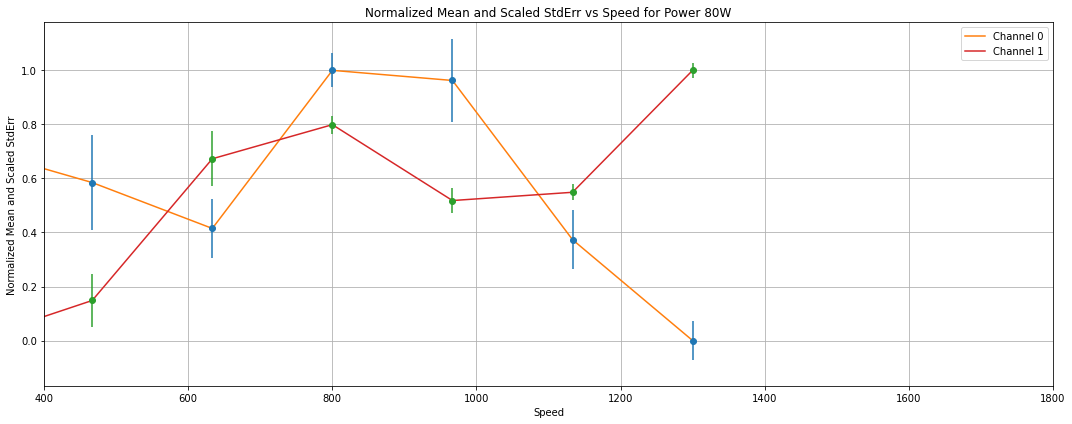

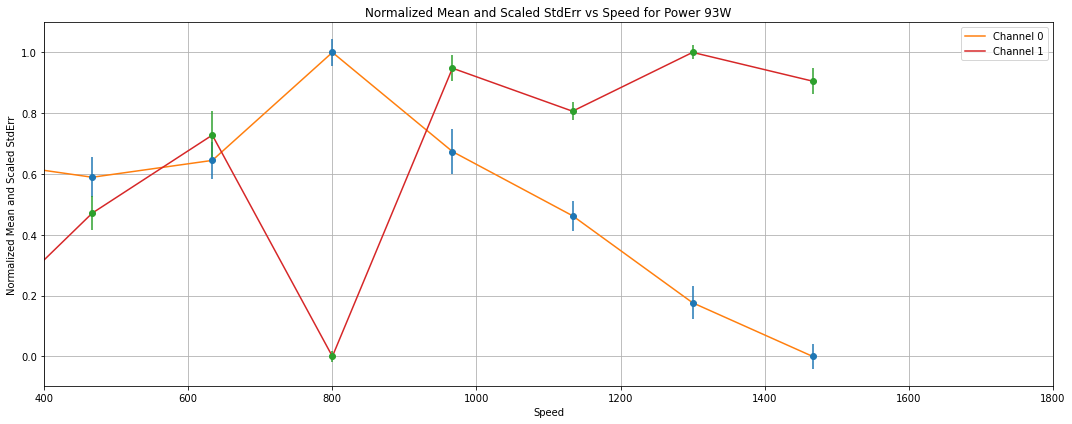

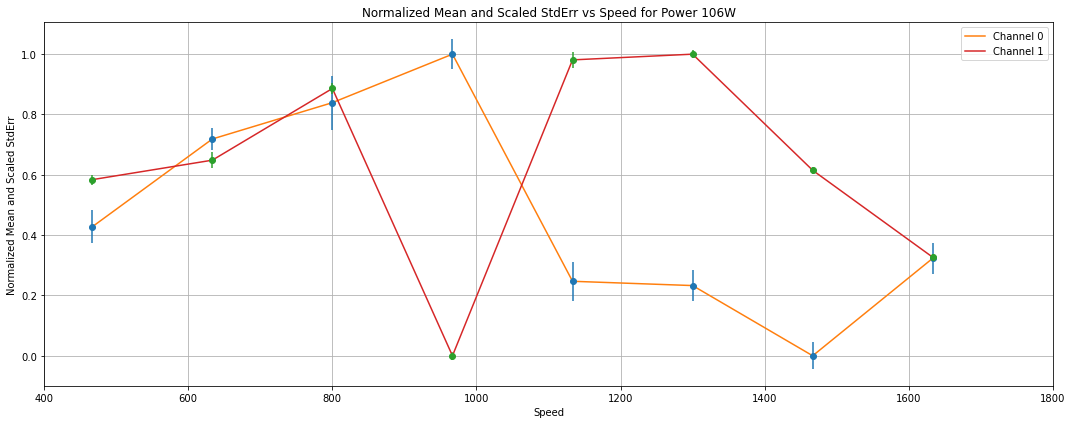

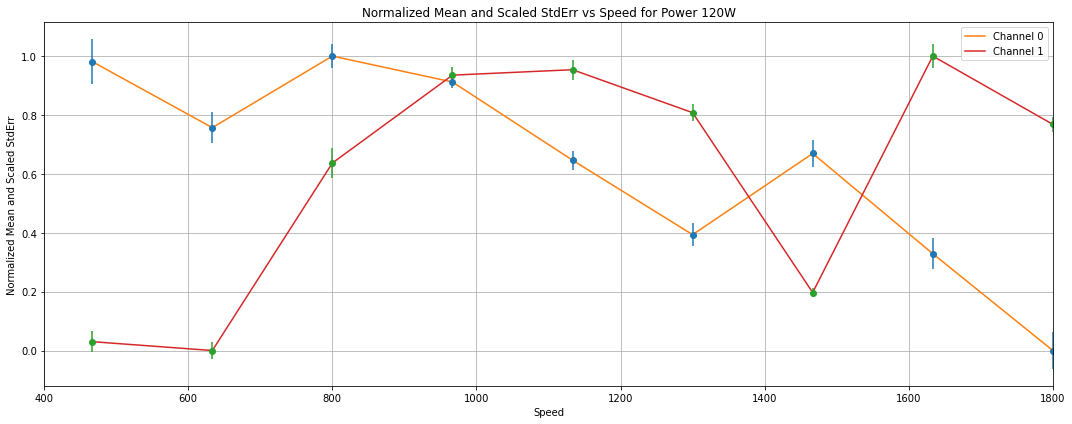

In [28]:
# Loop through unique power levels
for power in unique_powers:
    # Initialize data containers for the plots
    mean_data = {'channel_0': [], 'channel_1': []}
    std_data = {'channel_0': [], 'channel_1': []}
    speeds = []
    
    for channel in [0, 1]:
        # Retrieve speed, mean, and std data from stats dictionary
        speeds = new_stats[power][f'Channel {channel}']['Speed']
        mean_data[f'channel_{channel}'] = new_stats[power][f'Channel {channel}']['Median']
        std_data[f'channel_{channel}'] = new_stats[power][f'Channel {channel}']['StdErr']
    
    # Sort data by speed
    sorted_indices = np.argsort(speeds)
    speeds = np.array(speeds)[sorted_indices]
    
    for channel in [0, 1]:
        mean_data[f'channel_{channel}'] = np.array(mean_data[f'channel_{channel}'])[sorted_indices]
        std_data[f'channel_{channel}'] = np.array(std_data[f'channel_{channel}'])[sorted_indices]
        
        # Normalize the mean data and scale the standard deviation
        min_val = np.min(mean_data[f'channel_{channel}'])
        max_val = np.max(mean_data[f'channel_{channel}'])
        scaling_factor = 1 / (max_val - min_val)
        
        mean_data[f'channel_{channel}'] = (mean_data[f'channel_{channel}'] - min_val) * scaling_factor
        std_data[f'channel_{channel}'] = std_data[f'channel_{channel}'] * scaling_factor
    
    # Create a single plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for channel in [0, 1]:
        # Plot normalized error bars for both channels on the same plot without label
        ax.errorbar(speeds, mean_data[f'channel_{channel}'], yerr=std_data[f'channel_{channel}'], fmt='o')
        # Plot the line connecting the dots with label
        ax.plot(speeds, mean_data[f'channel_{channel}'], linestyle='-', marker='', label=f'Channel {channel}')
        
    # Set title, labels, legend, etc.
    ax.set_title(f'Normalized Mean and Scaled StdErr vs Speed for Power {int(power)}W')
    ax.set_xlabel('Speed')
    ax.set_ylabel('Normalized Mean and Scaled StdErr')
    ax.set_xlim([400, 1800])
    ax.legend()
    ax.grid(True)
        
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import moment

# Initialize an empty dictionary to store the moments for each condition
moments_dict = {}

# Loop over all conditions
for condition_number in range(len(final_data_list)):
    # Get information for the current condition (adding 1 to the condition number)
    condition_info = get_condition_info(condition_number + 1, df_conditions)

    # Extract the data for the current condition
    condition_data = final_data_list[condition_number]

    # Initialize a dictionary to hold the moments for this condition
    condition_moments = {'info': condition_info, 'channel_0': {}, 'channel_1': {}}

    # Compute the first 5 statistical moments for each channel
    for channel in range(2):
        # Average the segments for the current channel
        avg_data = np.mean(condition_data[channel][2:,:], axis=0)

        # Compute the first 5 moments: mean, variance, skewness, kurtosis, 5th moment
        moments = [np.mean(avg_data), np.var(avg_data)]
        moments.extend([moment(avg_data, moment=i) for i in range(3, 6)])

        # Add the moments to the dictionary
        channel_key = f'channel_{channel}'
        condition_moments[channel_key]['moments'] = moments

    # Add this condition's moments to the main dictionary
    moments_dict[condition_number + 1] = condition_moments


In [ ]:
import matplotlib.pyplot as plt

# Initialize the names of the moments for labeling
moment_names = ['Mean', 'Variance', 'Skewness', 'Kurtosis', '5th Moment']

# Loop through each channel
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    # Initialize the data for the scatter plots
    power = []
    speed = []
    moments = [[] for _ in range(5)]
    
    # Gather the data for the scatter plots
    for condition_number, condition_data in moments_dict.items():
        power.append(condition_data['info']['Powers (W)'])
        speed.append(condition_data['info']['Speed (mm/s)'])
        
        for i in range(5):
            moments[i].append(condition_data[channel_key]['moments'][i])
            
    # Create the 5 scatter plots for each moment
    for i, moment_name in enumerate(moment_names):
        plt.figure(figsize=(10, 8))
        plt.scatter(power, speed, c=moments[i], cmap='viridis')
        plt.colorbar(label=f'{moment_name}')
        plt.xlabel('Power')
        plt.ylabel('Speed')
        plt.title(f'Channel {channel} - {moment_name}')
        plt.show()


In [ ]:
# Initialize containers for normalized moments
normalized_moments = {'channel_0': [[] for _ in range(5)], 'channel_1': [[] for _ in range(5)]}

# Normalize the moments across all conditions for each channel and each moment type
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    for i in range(5):
        raw_moments = [condition_data[channel_key]['moments'][i] for condition_data in moments_dict.values()]
        min_val, max_val = min(raw_moments), max(raw_moments)
        
        normalized_moments[channel_key][i] = [(x - min_val) / (max_val - min_val) for x in raw_moments]

# Create the scatter plots for each normalized moment
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    # Initialize the data for the scatter plots
    power = []
    speed = []
    
    # Gather the data for the scatter plots
    for condition_number, condition_data in moments_dict.items():
        power.append(condition_data['info']['Powers (W)'])
        speed.append(condition_data['info']['Speed (mm/s)'])
            
    # Create the 5 scatter plots for each moment
    for i, moment_name in enumerate(moment_names):
        plt.figure(figsize=(10, 8))
        plt.scatter(power, speed, c=normalized_moments[channel_key][i], cmap='viridis')
        plt.colorbar(label=f'Normalized {moment_name}')
        plt.xlabel('Power')
        plt.ylabel('Speed')
        plt.title(f'Channel {channel} - Normalized {moment_name}')
        plt.show()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Loop through each channel
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    # Initialize the data for clustering
    clustering_data = []
    
    # Gather the data for clustering
    for condition_number, condition_data in moments_dict.items():
        moments = condition_data[channel_key]['moments']
        clustering_data.append(moments)

    clustering_data = np.array(clustering_data)
    
    # Step 2: Optimal k Analysis using the Elbow Method
    distortions = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, n_init=2)
        kmeans.fit(clustering_data)
        distortions.append(kmeans.inertia_)

    plt.figure()
    plt.plot(K_range, distortions, marker='o')
    plt.title(f'Elbow Method for Channel {channel}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

    # Choose the optimal k (you can also set this manually after observing the elbow plot)
    optimal_k = int(input(f"Enter the optimal number of clusters for channel {channel}: "))
    
    # Step 3: Final Clustering
    kmeans = KMeans(n_clusters=optimal_k, n_init=2)
    kmeans.fit(clustering_data)
    labels = kmeans.labels_

    # Step 4: Plotting the clusters in the power-speed plane, color-coded by cluster ID
    power = [condition_data['info']['Powers (W)'] for condition_data in moments_dict.values()]
    speed = [condition_data['info']['Speed (mm/s)'] for condition_data in moments_dict.values()]

    plt.figure(figsize=(10, 8))
    plt.scatter(power, speed, c=labels, cmap='viridis')
    plt.colorbar(label='Cluster ID')
    plt.xlabel('Power')
    plt.ylabel('Speed')
    plt.title(f'Clusters in Power-Speed Plane for Channel {channel} (Clusters based on moments only)')
    plt.show()


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Loop through each channel
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    # Initialize the data for clustering
    clustering_data = []
    
    # Gather the data for clustering
    for condition_number, condition_data in moments_dict.items():
        moments = condition_data[channel_key]['moments']
        clustering_data.append(moments)

    clustering_data = np.array(clustering_data)
    
    # Step 2: Optimal k Analysis using the Elbow Method
    distortions = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, n_init=2)
        kmeans.fit(clustering_data)
        distortions.append(kmeans.inertia_)

    plt.figure()
    plt.plot(K_range, distortions, marker='o')
    plt.title(f'Elbow Method for Channel {channel}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

    # Choose the optimal k (you can also set this manually after observing the elbow plot)
    optimal_k = int(input(f"Enter the optimal number of clusters for channel {channel}: "))
    
    # Step 3: Final Clustering
    kmeans = KMeans(n_clusters=optimal_k, n_init=2)
    kmeans.fit(clustering_data)
    labels = kmeans.labels_

    # Step 4: Plotting the clusters in the power-speed plane, labeled by cluster ID
    power = [condition_data['info']['Powers (W)'] for condition_data in moments_dict.values()]
    speed = [condition_data['info']['Speed (mm/s)'] for condition_data in moments_dict.values()]

    plt.figure(figsize=(10, 8))

    # Create a scatter plot for each cluster and add a legend entry for it
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = np.where(labels == label)
        plt.scatter(np.array(power)[idx], np.array(speed)[idx], label=f'Cluster {label + 1}')

    plt.xlabel('Power')
    plt.ylabel('Speed')

#     # Set the x and y-axis limits
#     plt.xlim(10, 350)
#     plt.ylim(50, 3000)

    plt.title(f'Clusters in Power-Speed Plane for Channel {channel} (Clusters based on moments only)')
    plt.legend(title='Clusters')

    plt.show()


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Loop through each channel
for channel in range(2):
    channel_key = f'channel_{channel}'
    
    # Initialize the data for clustering
    clustering_data = []
    
    # Gather the data for clustering
    for condition_number, condition_data in moments_dict.items():
        power = condition_data['info']['Powers (W)']
        speed = condition_data['info']['Speed (mm/s)']
        moments = condition_data[channel_key]['moments']
        clustering_data.append([power, speed] + moments)

    clustering_data = np.array(clustering_data)
    
    # Step 2: Optimal k Analysis using the Elbow Method
    distortions = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(clustering_data)
        distortions.append(kmeans.inertia_)

    plt.figure()
    plt.plot(K_range, distortions, marker='o')
    plt.title(f'Elbow Method for Channel {channel}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

    # Choose the optimal k (you can also set this manually after observing the elbow plot)
    optimal_k = int(input(f"Enter the optimal number of clusters for channel {channel}: "))
    
    # Step 3: Final Clustering and Plotting
    kmeans = KMeans(n_clusters=optimal_k)
    kmeans.fit(clustering_data)
    labels = kmeans.labels_

    plt.figure(figsize=(10, 8))
    plt.scatter(clustering_data[:, 0], clustering_data[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Cluster ID')
    plt.xlabel('Power')
    plt.ylabel('Speed')
    plt.title(f'Clusters in Power-Speed Plane for Channel {channel}')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Unique power levels
unique_powers = np.unique([condition_data['info']['Powers (W)'] for condition_data in moments_dict.values()])

# Loop through unique power levels
for power in unique_powers:
    # Initialize data containers for the plots
    mean_data = {'channel_0': [], 'channel_1': []}
    std_data = {'channel_0': [], 'channel_1': []}
    speeds = []
    
    # Loop through each condition to gather data
    for condition_number, condition_data in moments_dict.items():
        if condition_data['info']['Powers (W)'] == power:
            speeds.append(condition_data['info']['Speed (mm/s)'])
            
            for channel in [0, 1]:
                # Mean is the first moment
                mean_value = condition_data[f'channel_{channel}']['moments'][0]
                # Std is the square root of the second moment (variance)
                std_value = math.sqrt(condition_data[f'channel_{channel}']['moments'][1])
                
                mean_data[f'channel_{channel}'].append(mean_value)
                std_data[f'channel_{channel}'].append(std_value)
    
    # Sort data by speed
    sorted_indices = np.argsort(speeds)
    speeds = np.array(speeds)[sorted_indices]
    
    for channel in [0, 1]:
        mean_data[f'channel_{channel}'] = np.array(mean_data[f'channel_{channel}'])[sorted_indices]
        std_data[f'channel_{channel}'] = np.array(std_data[f'channel_{channel}'])[sorted_indices]
    
    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    for channel in [0, 1]:
        # Plot error bars
        axs[channel].errorbar(speeds, mean_data[f'channel_{channel}'], yerr=std_data[f'channel_{channel}'], fmt='o', label=f'Channel {channel}')
        # Plot the line connecting the dots
        axs[channel].plot(speeds, mean_data[f'channel_{channel}'], linestyle='-', marker='')
        
        axs[channel].set_title(f'Mean vs Speed for Power {int(power)}, Channel {channel}')
        axs[channel].set_xlabel('Speed')
        axs[channel].set_ylabel('Mean')
        axs[channel].legend()
        axs[channel].grid(True)
        
    plt.tight_layout()
    plt.show()
